In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

with open("audioss/labels.json","r") as f:
    labels = json.load(f)


In [6]:
def pad_mfcc(mfcc, max_len):
    # Se o MFCC for menor que o max_len, preenche com zeros
    pad_width = max_len - mfcc.shape[1]
    if pad_width > 0:
        return np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    return mfcc


In [24]:
audio_path = 'audioss/'
data = []
for x in labels:
    a = x[0]
    if(x[1]=='real'):
        g = 1

    if(x[1]=='fake'):
        g = 0
    apath = audio_path+a
    y, sr = librosa.load(apath)

    # Extrair os coeficientes MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = pad_mfcc(mfccs,600)
    #print(mfccs.shape,x[0])
    data.append([mfccs,g])

In [29]:
X = []
y = []
for x in data:
    X.append(x[0])
    y.append(x[1])
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=42)

# Ajustar a forma de y para ser categórica (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [30]:
# Definir a arquitetura do modelo CNN
def build_cnn(input_shape):
    model = tf.keras.models.Sequential()

    # Camada convolucional 1
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Camada convolucional 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Camada convolucional 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    # Flatten (achatar as camadas para entrada na camada densa)
    model.add(tf.keras.layers.Flatten())

    # Camada densa com ReLU
    model.add(tf.keras.layers.Dense(128, activation='relu'))

    # Camada de saída com Softmax (para classificação binária, 2 classes)
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

# Definir as dimensões de entrada para a CNN (40x1000 com 1 canal)
input_shape = (40, 600, 1)  # 1 canal para dados de áudio ou MFCC
X_train_reshaped = X_train[..., np.newaxis]  # Adicionar canal
X_test_reshaped = X_test[..., np.newaxis]    # Adicionar canal

# Criar o modelo
model = build_cnn(input_shape)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar a arquitetura do modelo
model.summary()

C:\Users\xluan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 38, 598, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 19, 299, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 17, 297, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 148, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 6, 146, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 3, 73, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 28032)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,588,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,681,154 (14.04 MB)

 Trainable params: 3,681,154 (14.04 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Treinamento do modelo
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.5070 - loss: 13.3090 - val_accuracy: 0.7679 - val_loss: 0.5747
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 676ms/step - accuracy: 0.6770 - loss: 0.5893 - val_accuracy: 0.7500 - val_loss: 0.4467
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 671ms/step - accuracy: 0.8289 - loss: 0.4226 - val_accuracy: 0.8750 - val_loss: 0.2466
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - accuracy: 0.8812 - loss: 0.2679 - val_accuracy: 0.8214 - val_loss: 0.2470
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 816ms/step - accuracy: 0.9245 - loss: 0.1719 - val_accuracy: 0.9107 - val_loss: 0.1926
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step - accuracy: 0.9099 - loss: 0.1978 - val_accuracy: 0.8393 - val_loss: 0.3624
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.9300 - loss: 0.1140 - val_accuracy: 0.9107 - val_loss: 0.1669
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step - accuracy: 0.9917 - loss: 0.0694 - val_accuracy: 0.9464 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8965 - loss: 0.5197
Acurácia no teste: 0.8999999761581421
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


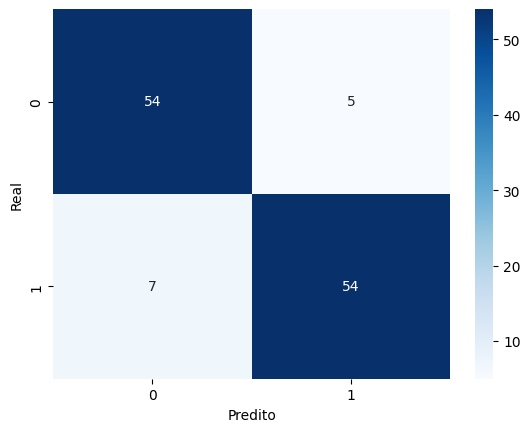

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        59
           1       0.92      0.89      0.90        61

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [32]:
# Avaliar o desempenho no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"Acurácia no teste: {test_acc}")

# Prever rótulos no conjunto de teste
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Relatório de classificação
print(classification_report(y_true, y_pred_classes))